### Создание графа Position network

In [40]:
import numpy as np
import re
from time import sleep
import chess 
import chess.pgn
import networkx as nx
import matplotlib.pyplot as plt

In [69]:
class Cell: 
    def __init__(self, x, y, t, c): 
        self.x = x 
        self.y = y 
        self.type = t
        self.color = c
        # вектор с "координатами" клеток, попадющих под бой фигуры, стоящей на этой клетке
        self.attack = [] 
        # вектор фигур, атакующих эту клетку
        self.attacked = []
        # вектор с "координатами" клеток, попадющих под защиту фигуры, стоящей на этой клетке
        self.defend = []
        
def move_by_black_pawn(pawn, cells):
    if (pawn.x - 1 >= 0) and (cells[pawn.x - 1][pawn.y].color == 0):
        pawn.attack.append((cells[pawn.x - 1][pawn.y].type, pawn.x - 1, pawn.y)) 
        cells[pawn.x - 1][pawn.y].attacked.append(pawn)
    if (pawn.x == 6) and (cells[pawn.x - 2][pawn.y].color == 0):
        pawn.attack.append((cells[pawn.x - 2][pawn.y].type, pawn.x - 2, pawn.y)) 
        cells[pawn.x - 2][pawn.y].attacked.append(pawn)
        
def move_by_white_pawn(pawn, cells):
    if (pawn.x + 1 < 8) and (cells[pawn.x + 1][pawn.y].color == 0):
        pawn.attack.append((cells[pawn.x + 1][pawn.y].type, pawn.x + 1, pawn.y)) 
        cells[pawn.x + 1][pawn.y].attacked.append(pawn)
    if pawn.x == 1 and (cells[pawn.x + 2][pawn.y].color == 0):
        pawn.attack.append((cells[pawn.x + 2][pawn.y].type, pawn.x + 2, pawn.y)) 
        cells[pawn.x + 2][pawn.y].attacked.append(pawn) 
    
def attack_by_black_pawn(pawn, cells):
    if (pawn.x - 1 >= 0) and (pawn.y - 1 >= 0) and (cells[pawn.x - 1][pawn.y - 1].color != 0): 
        pawn.attack.append((cells[pawn.x - 1][pawn.y - 1].type, pawn.x - 1, pawn.y - 1)) 
        cells[pawn.x - 1][pawn.y - 1].attacked.append(pawn) 
        
    if (pawn.x - 1 >= 0) and (pawn.y + 1 < 8) and (cells[pawn.x - 1][pawn.y + 1].color != 0): 
        pawn.attack.append((cells[pawn.x - 1][pawn.y + 1].type, pawn.x - 1, pawn.y + 1)) 
        cells[pawn.x - 1][pawn.y + 1].attacked.append(pawn)
        
def attack_by_white_pawn(pawn, cells):
    if (pawn.x + 1 < 8) and (pawn.y - 1 >= 0) and (cells[pawn.x + 1][pawn.y - 1].color != 0): 
        pawn.attack.append((cells[pawn.x + 1][pawn.y - 1].type, pawn.x + 1, pawn.y - 1)) 
        cells[pawn.x + 1][pawn.y - 1].attacked.append(pawn) 
        
    if (pawn.x + 1 < 8) and (pawn.y + 1 < 8) and (cells[pawn.x + 1][pawn.y + 1].color != 0): 
        pawn.attack.append((cells[pawn.x + 1][pawn.y + 1].type, pawn.x + 1, pawn.y + 1)) 
        cells[pawn.x + 1][pawn.y + 1].attacked.append(pawn)

def attack_by_knight(knight, cells): 
    moves = [(-1, 2), 
             (-2, 1), 
             (-2, -1), 
             (-1, -2), 
             (1, -2), 
             (2, -1), 
             (2, 1), 
             (1, 2)]
    
    for move in moves: 
        if (knight.x + move[0] >= 0) and (knight.x + move[0] < 8) and (knight.y + move[1] >= 0) and (knight.y + move[1] < 8): 
            if (knight.color != cells[knight.x + move[0]][knight.y + move[1]].color):
                knight.attack.append((cells[knight.x + move[0]][knight.y + move[1]].type, knight.x + move[0], knight.y + move[1]))
            elif (knight.color == cells[knight.x + move[0]][knight.y + move[1]].color):
                knight.defend.append((cells[knight.x + move[0]][knight.y + move[1]].type, knight.x + move[0], knight.y + move[1]))
            cells[knight.x + move[0]][knight.y + move[1]].attacked.append(knight)
            
def attack_by_bishop(bishop, cells): 
    move_x = bishop.x + 1 
    move_y = bishop.y + 1 
    
    while (move_x < 8) and (move_y < 8): 
        if (bishop.color != cells[move_x][move_y].color):
            bishop.attack.append((cells[move_x][move_y].type, move_x, move_y))
        else:
            bishop.defend.append((cells[move_x][move_y].type, move_x, move_y))
        cells[move_x][move_y].attacked.append(bishop) 
        
        if cells[move_x][move_y].type != 0: 
            break 
            
        move_x += 1 
        move_y += 1

    move_x = bishop.x + 1
    move_y = bishop.y - 1
    while (move_x < 8) and (move_y >= 0):
        if (bishop.color != cells[move_x][move_y].color):
            bishop.attack.append((cells[move_x][move_y].type, move_x, move_y))
        else:
            bishop.defend.append((cells[move_x][move_y].type, move_x, move_y))
        cells[move_x][move_y].attacked.append(bishop)
        
        if cells[move_x][move_y].type != 0:
            break
            
        move_x += 1
        move_y -= 1

    move_x = bishop.x - 1
    move_y = bishop.y - 1
    
    while (move_x >= 0) and (move_y >= 0):
        if (bishop.color != cells[move_x][move_y].color):
            bishop.attack.append((cells[move_x][move_y].type, move_x, move_y))
        else:
            bishop.defend.append((cells[move_x][move_y].type, move_x, move_y))
        cells[move_x][move_y].attacked.append(bishop)
        
        if cells[move_x][move_y].type != 0:
            break
            
        move_x -= 1
        move_y -= 1

    move_x = bishop.x - 1
    move_y = bishop.y + 1
    
    while (move_x >= 0) and (move_y < 8):
        if (bishop.color != cells[move_x][move_y].color):
            bishop.attack.append((cells[move_x][move_y].type, move_x, move_y))
        else:
            bishop.defend.append((cells[move_x][move_y].type, move_x, move_y))
        cells[move_x][move_y].attacked.append(bishop)
        
        if cells[move_x][move_y].type != 0:
            break
            
        move_x -= 1
        move_y += 1

        
def attack_by_rook(rook, cells): 
    move_x = rook.x + 1 
    
    while move_x < 8:
        if (rook.color != cells[move_x][rook.y].color):
            rook.attack.append((cells[move_x][rook.y].type, move_x, rook.y)) 
        else:
            rook.defend.append((cells[move_x][rook.y].type, move_x, rook.y)) 
        cells[move_x][rook.y].attacked.append(rook) 
        
        if cells[move_x][rook.y].type != 0: 
            break 
        move_x += 1

    move_x = rook.x - 1
    
    while move_x >= 0:
        if (rook.color != cells[move_x][rook.y].color):
            rook.attack.append((cells[move_x][rook.y].type, move_x, rook.y))
        else:
            rook.defend.append((cells[move_x][rook.y].type, move_x, rook.y))
        cells[move_x][rook.y].attacked.append(rook)
            
        if cells[move_x][rook.y].type != 0:
            break
        move_x -= 1

    move_y = rook.y + 1
    
    while move_y < 8:
        if (rook.color != cells[rook.x][move_y].color):
            rook.attack.append((cells[rook.x][move_y].type, rook.x, move_y))
        else:
            rook.defend.append((cells[rook.x][move_y].type, rook.x, move_y))
        cells[rook.x][move_y].attacked.append(rook)
            
        if cells[rook.x][move_y].type != 0:
            break
        move_y += 1

    move_y = rook.y - 1
    
    while move_y >= 0:
        if (rook.color != cells[rook.x][move_y].color):
            rook.attack.append((cells[rook.x][move_y].type, rook.x, move_y))
        else:
            rook.defend.append((cells[rook.x][move_y].type, rook.x, move_y))
        cells[rook.x][move_y].attacked.append(rook)
            
        if cells[rook.x][move_y].type != 0:
            break
        move_y -= 1

        
def attack_by_queen(queen, cells): 
    attack_by_rook(queen, cells) 
    attack_by_bishop(queen, cells)
    
    
def attack_by_king(king, cells): 
    moves = [(-1, 0), (-1, 1), (-1, -1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)] 
    
    for move in moves: 
        if (king.x + move[0] >= 0) and (king.x + move[0] < 8) and (king.y + move[1] >= 0) and (king.y + move[1] < 8):
            if (king.color != cells[king.x + move[0]][king.y + move[1]].color):
                king.attack.append((cells[king.x + move[0]][king.y + move[1]].type, king.x + move[0], king.y + move[1]))
            else:
                king.defend.append((cells[king.x + move[0]][king.y + move[1]].type, king.x + move[0], king.y + move[1]))
            cells[king.x + move[0]][king.y + move[1]].attacked.append(king)
            
def castling_king(king, cells, board):
    if king.color == 1:
        if board.has_kingside_castling_rights(chess.WHITE) and cells[0][5].color == 0 and cells[0][6].color == 0:
            king.attack.append((cells[0][6].type, 0, 6))
            cells[0][6].attacked.append(king)
        elif board.has_queenside_castling_rights(chess.WHITE) and cells[0][1].color == 0 and cells[0][2].color == 0 and cells[0][3].color == 0:
            king.attack.append((cells[0][2].type, 0, 2))
            cells[0][2].attacked.append(king)
    
    if king.color == -1:
        if board.has_kingside_castling_rights(chess.BLACK) and cells[7][5].color == 0 and cells[7][6].color == 0:
            king.attack.append((cells[7][6].type, 7, 6))
            cells[7][6].attacked.append(king)
        elif board.has_queenside_castling_rights(chess.BLACK) and cells[7][1].color == 0 and cells[7][2].color == 0 and cells[7][3].color == 0:
            king.attack.append((cells[7][2].type, 7, 2))
            cells[7][2].attacked.append(king)
                               
def castling_rook(rook, cells, board):
    if rook.color == 1:
        if board.has_kingside_castling_rights(chess.WHITE) and cells[0][5].color == 0 and cells[0][6].color == 0:
            rook.attack.append((cells[0][5].type, 0, 5))
            cells[0][5].attacked.append(rook)
        elif board.has_queenside_castling_rights(chess.WHITE) and cells[0][1].color == 0 and cells[0][2].color == 0 and cells[0][3].color == 0:
            rook.attack.append((cells[0][3].type, 0, 3))
            cells[0][3].attacked.append(rook)
    
    if rook.color == -1:
        if board.has_kingside_castling_rights(chess.BLACK) and cells[7][5].color == 0 and cells[7][6].color == 0:
            rook.attack.append((cells[7][5].type, 7, 5))
            cells[7][5].attacked.append(rook)
        elif board.has_queenside_castling_rights(chess.BLACK) and cells[7][1].color == 0 and cells[7][2].color == 0 and cells[7][3].color == 0:
            rook.attack.append((cells[7][3].type, 7, 3))
            cells[7][3].attacked.append(rook)

In [70]:
def define_figures(board, chess_board): 
    figures = [] 
    cells = [[] for _ in range(8)] 

    for i in range(8): 
        for j in range(8): 
            if board[i][j] == 0:
                cells[i].append(Cell(i, j, board[i][j], 0))
            elif board[i][j].islower():
                figures.append(Cell(i, j, board[i][j], -1))
                cells[i].append(Cell(i, j, board[i][j], -1))
            elif board[i][j].isupper():
                figures.append(Cell(i, j, board[i][j], 1))
                cells[i].append(Cell(i, j, board[i][j], 1))


    for figure in figures: 
        if figure.type == 'p':
            move_by_black_pawn(figure, cells)
            attack_by_black_pawn(figure, cells)
        elif figure.type == 'P': 
            move_by_white_pawn(figure, cells)
            attack_by_white_pawn(figure, cells)
        elif figure.type == 'n' or figure.type == 'N': 
            attack_by_knight(figure, cells)
        elif figure.type == 'b' or figure.type == 'B': 
            attack_by_bishop(figure, cells) 
        elif figure.type == 'r' or figure.type == 'R': 
            attack_by_rook(figure, cells)
            castling_rook(figure, cells, chess_board)
        elif figure.type == 'q' or figure.type == 'Q': 
            attack_by_queen(figure, cells) 
        elif figure.type == 'k' or figure.type == 'K': 
            attack_by_king(figure, cells)
            castling_king(figure, cells, chess_board)
            
    return figures

In [71]:
def board_to_array(board):
    # Создаем пустой двумерный массив размером 8x8
    board_array = [[None for j in range(8)] for i in range(8)]

    # Проходим по каждой позиции на шахматной доске
    for row in range(8):
        for col in range(8):
            # Получаем фигуру с позиции и преобразуем её в символ
            piece = board.piece_at(8 * row + col)
            symbol = piece.symbol() if piece else 0

            # Сохраняем символ фигуры в двумерный массив
            board_array[row][col] = symbol

    return board_array

In [80]:
import os
import pickle

import subprocess
from tqdm import tqdm
import chess

def count_games(input_file_path):
    # Команда, которую мы хотим выполнить в bash
    command = f'grep -o -w "Event" {input_file_path} | wc -l'

    # Выполнение команды и получение вывода
    output = subprocess.check_output(command, shell=True)

    # Преобразование вывода в строку и вывод результата
    count = int(output.decode('utf-8').strip())
    return count

def create_graph(board, graphs, letters):
    board_array = board_to_array(board)
    figures = define_figures(board_array, board)
    G = nx.DiGraph()
    for figure in figures:
#         print(figure.type, figure.x, figure.y, figure.attack + figure.defend)
        first = str(figure.type) + letters[figure.y] + str(figure.x + 1)
        for cell_attacked in figure.attack:  
            if (cell_attacked[0] != 0):
                second = str(cell_attacked[0]) + letters[cell_attacked[2]] + str(cell_attacked[1] + 1)
            else:
                second = letters[cell_attacked[2]] + str(cell_attacked[1] + 1)
            G.add_edge(first, second)
        
        for cell_defened in figure.defend:  
            if (cell_defened[0] != 0):
                second = str(cell_defened[0]) + letters[cell_defened[2]] + str(cell_defened[1] + 1)
            else:
                second = letters[cell_defened[2]] + str(cell_defened[1] + 1)
            G.add_edge(first, second)

    graphs.append(G)

def create_position_network(input_file_path, output_dir):
    if not os.path.exists(output_dir): 
        os.makedirs(output_dir)
    total_games = 100
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    with open(input_file_path) as pgn_file:
        for i in tqdm(range(total_games), desc="Processing games", unit="game"):
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            board = chess.Board()
            graphs = []
            create_graph(board, graphs, letters)
            for number, move in enumerate(game.mainline_moves()): 
                    board.push(move)
                    create_graph(board, graphs, letters)
                    
            temp = input_file_path.split('.')[0]
            output_path = f'{output_dir}/{temp}_{i}/{game.headers.get("White")}/{game.headers.get("Black")}/{game.headers.get("Result")}/{game.headers.get("WhiteElo")}/{game.headers.get("BlackElo")}/{game.headers.get("Opening")}/{game.headers.get("Variation")}.pickle'
            with open(output_path, "wb") as f:
                pickle.dump(graphs, f)

In [81]:
create_position_network("database_part7.pgn", "position_network")

Processing games: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.70game/s]


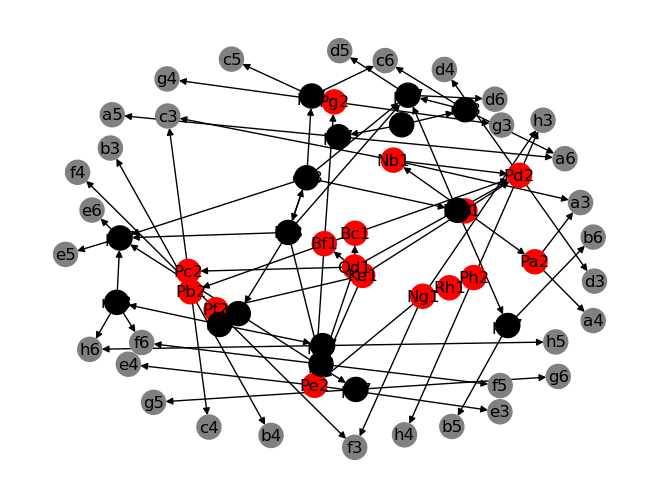

In [86]:
with open("position_network/database_part7_9.pickle", 'rb') as f:
    graphs = pickle.load(f)
colors = []
for node in graphs[0].nodes(data=True):
    if len(node[0]) == 2:
        colors.append("grey")
    elif node[0][0].isupper():
        colors.append("red")
    else:
        colors.append("black")

nx.draw(graphs[0], with_labels=True, node_color=colors)

In [87]:
import os
import concurrent.futures

def save_output_to_file(output, file_name):
    with open(file_name, 'w') as f:
        f.write(output)


input_folder = os.getcwd() # Текущая директория
output_folder = 'position_network'

# Создаем папки для изображений и логов, если они ещё не существуют
os.makedirs(output_folder, exist_ok=True)

# Получаем список файлоw, начинающихся с "database_part"
files = [f.split('/')[-1] for f in os.listdir(input_folder) if f.startswith('database_part')]

# Используем ThreadPoolExecutor для выполнения функций в параллельных потоках
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Отправляем задачи на выполнение
    future_to_file = {executor.submit(create_position_network, file, output_folder): file for file in files}

    # Обрабатываем результаты выполнения
    for future in concurrent.futures.as_completed(future_to_file):
        file = future_to_file[future]
        try:
            output = future.result()
        except Exception as exc:
            print(f'Файл {file} вызвал исключение: {exc}')
        else:
            print("успех")


Processing games:   0%|                                                                                                                                                           | 0/100 [00:00<?, ?game/s]

Processing games:   1%|█▍                                                                                                                                                 | 1/100 [00:00<00:29,  3.40game/s]


Processing games:   0%|                                                                                                                                                           | 0/100 [00:00<?, ?game/s]




Processing games:   0%|                                                                                                                                                           | 0/100 [00:00<?, ?game/s]





Processing games:   0%|                                                                                                                                                

Processing games:   8%|███████████▊                                                                                                                                       | 8/100 [00:04<00:42,  2.17game/s]



Processing games:   9%|█████████████▏                                                                                                                                     | 9/100 [00:04<00:42,  2.12game/s]








Processing games:   8%|███████████▊                                                                                                                                       | 8/100 [00:03<00:43,  2.11game/s]

Processing games:  11%|████████████████                                                                                                                                  | 11/100 [00:04<00:42,  2.09game/s]




Processing games:  10%|██████████████▌                                                                                                                              

Processing games:  15%|█████████████████████▉                                                                                                                            | 15/100 [00:07<00:42,  2.02game/s]








Processing games:  16%|███████████████████████▎                                                                                                                          | 16/100 [00:07<00:39,  2.12game/s]

Processing games:  19%|███████████████████████████▋                                                                                                                      | 19/100 [00:08<00:35,  2.27game/s]



Processing games:  18%|██████████████████████████▎                                                                                                                       | 18/100 [00:08<00:37,  2.18game/s]





Processing games:  18%|██████████████████████████▎                                                                                                                 

Processing games:  23%|█████████████████████████████████▌                                                                                                                | 23/100 [00:12<00:42,  1.82game/s]








Processing games:  26%|█████████████████████████████████████▉                                                                                                            | 26/100 [00:13<00:38,  1.90game/s]

Processing games:  27%|███████████████████████████████████████▍                                                                                                          | 27/100 [00:13<00:39,  1.83game/s]



Processing games:  25%|████████████████████████████████████▌                                                                                                             | 25/100 [00:12<00:41,  1.80game/s]





Processing games:  26%|█████████████████████████████████████▉                                                                                                      

Processing games:  34%|█████████████████████████████████████████████████▋                                                                                                | 34/100 [00:16<00:31,  2.10game/s]








Processing games:  32%|██████████████████████████████████████████████▋                                                                                                   | 32/100 [00:15<00:33,  2.04game/s]



Processing games:  33%|████████████████████████████████████████████████▏                                                                                                 | 33/100 [00:16<00:31,  2.10game/s]

Processing games:  35%|███████████████████████████████████████████████████                                                                                               | 35/100 [00:16<00:30,  2.13game/s]





Processing games:  34%|█████████████████████████████████████████████████▋                                                                                          

Processing games:  42%|█████████████████████████████████████████████████████████████▎                                                                                    | 42/100 [00:20<00:28,  2.03game/s]



Processing games:  41%|███████████████████████████████████████████████████████████▊                                                                                      | 41/100 [00:20<00:28,  2.06game/s]








Processing games:  40%|██████████████████████████████████████████████████████████▍                                                                                       | 40/100 [00:19<00:30,  1.96game/s]

Processing games:  43%|██████████████████████████████████████████████████████████████▊                                                                                   | 43/100 [00:20<00:27,  2.06game/s]


Processing games:  41%|███████████████████████████████████████████████████████████▊                                                                                   

Processing games:  49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 49/100 [00:24<00:25,  2.03game/s]






Processing games:  47%|████████████████████████████████████████████████████████████████████▌                                                                             | 47/100 [00:23<00:25,  2.07game/s]








Processing games:  48%|██████████████████████████████████████████████████████████████████████                                                                            | 48/100 [00:23<00:24,  2.14game/s]

Processing games:  51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 51/100 [00:24<00:23,  2.10game/s]


Processing games:  49%|███████████████████████████████████████████████████████████████████████▌                                                                    

Processing games:  57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 57/100 [00:27<00:21,  2.00game/s]






Processing games:  55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 55/100 [00:28<00:23,  1.95game/s]

Processing games:  59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 59/100 [00:28<00:21,  1.89game/s]








Processing games:  56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 56/100 [00:27<00:22,  1.95game/s]


Processing games:  57%|███████████████████████████████████████████████████████████████████████████████████▏                                                        

Processing games:  65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 65/100 [00:32<00:16,  2.08game/s]

Processing games:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 67/100 [00:32<00:15,  2.20game/s]



Processing games:  65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 65/100 [00:31<00:17,  1.98game/s]


Processing games:  65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 65/100 [00:32<00:16,  2.18game/s]








Processing games:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                             

Processing games:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 73/100 [00:35<00:13,  2.06game/s]






Processing games:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 71/100 [00:35<00:15,  1.91game/s]


Processing games:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 75/100 [00:36<00:12,  2.06game/s]

Processing games:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 75/100 [00:36<00:13,  1.90game/s]








Processing games:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   

Processing games:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 79/100 [00:39<00:09,  2.29game/s]



Processing games:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 81/100 [00:39<00:08,  2.23game/s]




Processing games:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 80/100 [00:39<00:08,  2.35game/s]


Processing games:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 81/100 [00:39<00:09,  2.10game/s]

Processing games:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        |

Processing games:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 87/100 [00:43<00:06,  2.08game/s]




Processing games:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 88/100 [00:43<00:05,  2.08game/s]



Processing games:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 89/100 [00:43<00:05,  2.10game/s]








Processing games:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 88/100 [00:42<00:05,  2.24game/s]


Processing games:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       

Processing games:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:47<00:02,  2.16game/s]




Processing games:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:47<00:01,  2.14game/s]



Processing games:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:47<00:01,  2.15game/s]








Processing games:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:46<00:01,  2.16game/s]


Processing games:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

успех
успех
успех











Processing games: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.77game/s]


Processing games: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03game/s]








Processing games: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.05game/s]







Processing games: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.05game/s]

успех
успех
успех
успех
успех
успех
успех
